wl_des: 17.86, wr_des: 17.86

duty cycle l: 1.0, r: 1.0
accum err: l: 17.36, r: 17.36
prev err: l: 17.36, r: 17.36


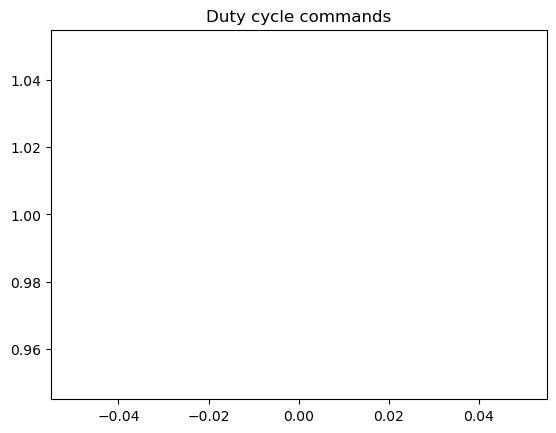

In [24]:
from matplotlib import pyplot as plt

# Physical dimensions
WHEEL_RADIUS = 0.028 # meters
WHEEL_SEP = 0.222 # meters




class RobotController:
    
    def __init__(self, Kp=0.2, Ki=0.0, Kd=0, wheel_radius=WHEEL_RADIUS, wheel_sep=WHEEL_SEP):
        
        self.Kp = Kp # Proportional gain
        self.Ki = Ki # Integral gain
        self.Kd = Kd # Derivative gain (I don't think we'll need this but we'll see)
        self.r = wheel_radius
        self.l = wheel_sep
        self.e_sum_l = 0 # the accumulated sum of the errors for the left wheel over time
        self.e_sum_r = 0 # the accumulated sum of the errors for the right wheel over time
        self.e_l_prev = 0 # the previous error for the left wheel, just for the previous iteration of the control loop
        self.e_r_prev = 0  # the previous error for the right wheel, just for the previous iteration of the control loop
    
    """
    I wrote this method as part of an experiment to see what was wrong (and still seems wrong) with the PI controller.
    - Essentially, with our current PI controller, even if the wheel error is large (e.g. the wheel is spinning much faster than it should be), the duty cycle is still very large, above 1, meaning it doesn't slow down and also keeps being 'saturated' at 1.
    - If you have a look at Michael's p_control method or my PID_control method, you'll see that they both 'clamp' or cap the duty cycles to ensure they're within the range of -1 to 1. This means that even if the left and right duty cycle values are both different values that are above or below 1, e.g. 1.57 and 2.3, they still get output as 1. This means that the relationship between the two duty cycles also gets lost, and we end up with 1 and 1 for left and right motor duty cycles.
    - And so, for my experiment, I decided to remove the duty cycle 'clamping' or cap in the p_control method and use this method instead to scale the duty cycles to be within 1 or -1, but still retain their proportionality to each other.
        - So for the previous example, instead of 1.57 and 2.3 getting turned into 1 and 1, they'd get turned into 0.68 and 1.
        - And this actually seemed to work somewhat! But you'll notice that I commented out the code that uses this method in the pid_control method as I was testing something else today (Friday 23/08/2024). 
    - Feel free to reenable this and modify pid_control and see what happens.
    """
    def scale_velocities(self, duty_cycle_l, duty_cycle_r):
            
        # Find the maximum absolute duty cycle
        max_duty = max(abs(duty_cycle_l), abs(duty_cycle_r))

        # If max_duty is greater than 1, scale both duty cycles
        if max_duty > 1:
            duty_cycle_l /= max_duty
            duty_cycle_r /= max_duty

        return duty_cycle_l, duty_cycle_r
    
    """
    This p_control method is pretty much identical to Michael's p_control in the ECE4191 repo, except that it actually integrates the error over time. We're not using this, instead we're using the method below.
    """
#     def p_control(self, w_desired, w_measured, e_sum, dt):
#         error = w_desired - w_measured
#         p_term = self.Kp * error
#         i_term = self.Ki * e_sum * dt  # Note: Integrate error over time
# #         duty_cycle = min(max(-1, p_term + i_term), 1)
#         duty_cycle = p_term + i_term
#         e_sum = e_sum + error * dt  # Accumulate error over actual time
        
#         return duty_cycle, e_sum
    
    """
    This is just the p_control method with an added d term that we're currently not using. I was testing it out to see if it would help with the wheel control, but it didn't seem to do much.
    """
    def pid_control(self, w_desired, w_measured, e_sum, last_error, dt):
        error = w_desired - w_measured
        p_term = self.Kp * error
        i_term = self.Ki * e_sum * dt
        d_term = self.Kd * (error - last_error) / dt

        duty_cycle = p_term + i_term + d_term
#         duty_cycle = min(max(-1, duty_cycle), 1)

#         # Anti-windup
#         if abs(duty_cycle) < 1:
#             e_sum = e_sum + error * dt
        e_sum = e_sum + error  # Accumulate error over actual time

        return duty_cycle, e_sum, error

    """
    This is the main method that we use to control the robot's motion. It takes in the desired linear and angular velocities, and the measured wheel velocities, and calculates the duty cycles for the left and right motors.
    It uses the pid_control method to calculate the duty cycles.
    - I think this is where the issue is coming from, where we input a v_desired of 0.5m/s but we still get something like 2m/s coming out of the motors. Please help me.
    """
    def drive(self, v_desired, w_desired, wl, wr, dt):
        # v_desired: m/s, w_desired (rotation): rad/s
        # wl and wr (wheel ang. vel. for left and right): rad/s
        
        wl_desired = (v_desired + self.l*w_desired/2)/self.r # rad/s
        wr_desired = (v_desired - self.l*w_desired/2)/self.r # rad/s
        print(f"wl_des: {wl_desired:.2f}, wr_des: {wr_desired:.2f}")
        
#         duty_cycle_l, self.e_sum_l = self.p_control(wl_desired, wl, self.e_sum_l, dt)
#         duty_cycle_r, self.e_sum_r = self.p_control(wr_desired, wr, self.e_sum_r, dt)
        
            
        duty_cycle_l, self.e_sum_l, self.e_l_prev = self.pid_control(wl_desired, wl, self.e_sum_l, self.e_l_prev, dt)
        duty_cycle_r, self.e_sum_r, self.e_r_prev = self.pid_control(wr_desired, wr, self.e_sum_r, self.e_r_prev, dt)
        
        
        # Normalise duty cycles to 1
        duty_cycle_l, duty_cycle_r = self.scale_velocities(duty_cycle_l, duty_cycle_r)

        return duty_cycle_l, duty_cycle_r
    
    

class TestData:
    def __init__(self, v_desired, w_desired, v_actual, w_actual, dt):
        self.v_desired = v_desired
        self.w_desired = w_desired
        self.v_actual = v_actual
        self.w_actual = w_actual
        self.dt = dt
     
     
     
        
# Parameters
Kp = 0.3
Ki = 0.01

# Initialising
controller = RobotController(Kp, Ki)

poses = []
velocities = []
duty_cycle_commands = []

# TestData( v_desired, w_desired, v_actual, w_actual, dt)
data = [
    TestData(0.5, 0.0, 0.5, 0.5, 0.1),
    # TestData( 0.50, 0.0, 1.27, 1.66, 0.12),
    # TestData( 0.50,  0.0, 1.38,  1.76, 0.1),
    # TestData( 0.50, 0.0, 1.38, 1.76, 0.12),
]

for i in data:
    duty_cycle_l, duty_cycle_r = controller.drive(i.v_desired, i.w_desired, i.v_actual, i.w_actual, i.dt)
    print(f"\nduty cycle l: {duty_cycle_l}, r: {duty_cycle_r}")
    print(f"accum err: l: {controller.e_sum_l:.2f}, r: {controller.e_sum_r:.2f}")
    print(f"prev err: l: {controller.e_l_prev:.2f}, r: {controller.e_r_prev:.2f}")
    duty_cycle_commands.append([duty_cycle_l,duty_cycle_r])
    
plt.figure()
plt.plot(duty_cycle_commands)
plt.title("Duty cycle commands")
plt.show()


In [ ]:






# Example: Move forward at 0.5 m/s with no rotation
v_desired = 0.5
w_desired = 0.1